In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import random
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import os.path
from tqdm import tqdm
import math
import cv2 as cv
import glob
from skimage.color import rgb2gray
%matplotlib inline
from scipy import ndimage
from PIL import Image
from sklearn.cluster import KMeans
from skimage.filters import sobel
import skimage
import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_original_images():
    img_folder_path = 'F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\1-20\\'
    imgs = []
    for file in tqdm(os.listdir(img_path)):
        imgs.append(np.array(Image.open(img_folder_path + file)))
    # both input images are from 0-->255
    #print(imgs)
    return imgs

In [3]:
img_folder_path = 'F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\1-20\\'
output_path = 'Output'

In [4]:
def helper(image):
    gray_img = cv.imread(image,0)
    
    enh_img_hst = cv.equalizeHist(gray_img)
    
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enh_img_clahe = clahe.apply(gray_img)
    
    return enh_img_clahe,enh_img_hst,gray_img

In [5]:
 def plot_helper(gray_img, enh_img_hst, enh_img_clahe):
        fig = plt.figure(figsize=(10, 7))
        rows = 1
        columns = 3
        res_img = [gray_img, enh_img_hst, enh_img_clahe]
        res_img_title = ['Input Image', 'Histogram Equalized', 'Enhanced Histogram Equalized']

        #cv.imwrite(f'enh_img_hst{img_id}.png',enh_img_clahe)


        for idx in range(1,columns):
            fig.add_subplot(rows, columns, idx+1)
            plt.imshow(res_img[idx], cmap='gray')
            plt.axis('off')
            plt.title(res_img_title[idx])

In [6]:
def enhance_image(image_path,i):
    all_img = glob.glob('.')
    #other_dir = 'new_path'
    for img_id, img_path in enumerate(all_img):
        if 'a' in image_path[-10:]:
            enh_img_clahe,enh_img_hst,gray_img = helper(image_path)
            
            cv.imwrite(f'{output_path}\\enh_img_hist_a{i+1}.png',enh_img_hst)
            cv.imwrite(f'{output_path}\\enh_img_clahe_a{i+1}.png',enh_img_clahe)
            
            #plot_helper(gray_img, enh_img_hst, enh_img_clahe)
            return gray_img,enh_img_hst,enh_img_clahe
            
            
        elif 'b' in image_path[-10:]:
            enh_img_clahe,enh_img_hst,gray_img = helper(image_path)
            
            cv.imwrite(f'{output_path}\\enh_img_hist_b{i+1}.png',enh_img_hst)
            cv.imwrite(f'{output_path}\\enh_img_clahe_b{i+1}.png',enh_img_clahe)
            
            #plot_helper(gray_img, enh_img_hst, enh_img_clahe)
            return gray_img,enh_img_hst,enh_img_clahe

In [7]:
def edge_detection(img, lower_th = None, upper_th = None):
             
    # Noise reduction step
    img = cv.GaussianBlur(img, (5, 5), 1.4)
    
    # Calculating the gradients
    gx = cv.Sobel(np.float32(img), cv.CV_64F, 1, 0, 3)
    gy = cv.Sobel(np.float32(img), cv.CV_64F, 0, 1, 3)
      
    # Conversion of Cartesian coordinates to polar 
    mag, ang = cv.cartToPolar(gx, gy, angleInDegrees = True)
       
    # set the minimum and maximum thresholds as lower and upper 
    mag_max = np.max(mag)
    if not lower_th:lower_th = mag_max * 0.1
    if not upper_th:upper_th = mag_max * 0.5
      
    # getting the dimensions of the input image  
    height, width = img.shape
       
    # Looping through every pixel of the grayscale 
    # image
    for i_x in range(width):
        for i_y in range(height):
               
            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
               
            # selecting the neighbours of the target pixel according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
              
            # top right (diagnol-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
              
            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
              
            # top left (diagnol-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1
              
            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
               
            # Non-maximum suppression step
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x]= 0
                    continue
   
            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x]= 0
   
    lower_ids = np.zeros_like(img)
    upper_ids = np.zeros_like(img)              
    ids = np.zeros_like(img)
       
    # double thresholding step
    for i_x in range(width):
        for i_y in range(height):
              
            grad_mag = mag[i_y, i_x]
              
            if grad_mag < lower_th:
                mag[i_y, i_x]= 0
            elif upper_th > grad_mag>= lower_th:
                ids[i_y, i_x]= 1
            else:
                ids[i_y, i_x]= 2
    #plt.imshow(mag, cmap='gray')      
    # returning the magnitude of gradients of edges
    return mag

In [8]:
def plot_edge_helper(gray_img, enh_img_clahe, canny_img_clahe):
    result_img = [gray_img, enh_img_clahe, canny_img_clahe]
    result_img_title = ['Input Image', 'Enhanced Image', 'Detected Edges']

    # create figure
    fig = plt.figure(figsize=(10, 7))

    # setting values to rows and column variables
    rows = 1
    columns = 3

    for idx in range(columns):
        fig.add_subplot(rows, columns, idx+1)
        plt.imshow(result_img[idx], cmap='gray')
        plt.axis('off')
        plt.title(result_img_title[idx])

In [9]:
def preprocess(img_folder_path):
    for i,file in enumerate(os.listdir(img_folder_path)):
        #print (img_path+file)
        gray_img,enh_img_hst,enh_img_clahe=enhance_image(img_folder_path+file,i)
        plot_helper(gray_img, enh_img_hst, enh_img_clahe)

        canny_gray_img = edge_detection(gray_img)
        canny_img_hist = edge_detection(enh_img_hst)
        canny_img_clahe = edge_detection(enh_img_clahe)

        plot_edge_helper(gray_img, enh_img_clahe, canny_img_clahe)

In [10]:
def preprocess_single_img(image_path,i=0):
    gray_img,enh_img_hst,enh_img_clahe=enhance_image(image_path,i=i)
    plot_helper(gray_img, enh_img_hst, enh_img_clahe)

    canny_gray_img = edge_detection(gray_img)
    canny_img_hist = edge_detection(enh_img_hst)
    canny_img_clahe = edge_detection(enh_img_clahe)

    plot_edge_helper(gray_img, enh_img_clahe, canny_img_clahe)

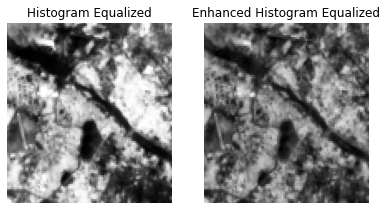

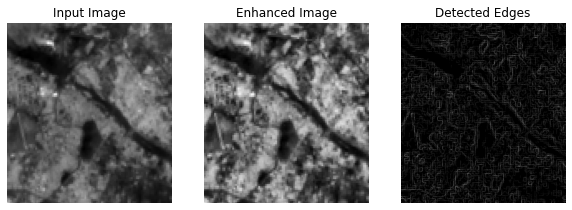

In [11]:
preprocess_single_img(img_folder_path+"img_a1.png",i=0)
#preprocess_single_img(img_folder_path+"img_b1.png",i=0)

In [13]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import random
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import os.path
from tqdm import tqdm
import math


def print_img(img, histo_new, histo_old, index, L):
    dpi = 80
    width = img.shape[0]
    height = img.shape[1]
    if height > width:
        figsize = (img.shape[0]*4) / float(dpi), (height)/ float(dpi)
        fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [3, 1,1]}, figsize=figsize)
    else:
        figsize = (width) / float(dpi), (height*4) / float(dpi)
        fig, axs = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3, 1,1]}, figsize=figsize)

    fig.suptitle("Enhanced Image with L:" + str(L))
    axs[0].title.set_text("Enhanced Image")
    axs[0].imshow(img, vmin=np.amin(img), vmax=np.amax(img), cmap='gray')

    axs[1].title.set_text("Equalized histogram")
    axs[1].plot(histo_new, color='#f77f00')
    axs[1].bar(np.arange(len(histo_new)), histo_new, color='#003049')

    axs[2].title.set_text("Main histogram")
    axs[2].plot(histo_old, color='#ef476f')
    axs[2].bar(np.arange(len(histo_old)), histo_old, color='#b7b7a4')
    plt.tight_layout()
    #plt.savefig("e" + index + str(L)+".pdf")
    #plt.savefig("e" + index + str(L)+".png")


def print_histogram(_histrogram, name, title):
    plt.figure()
    plt.title(title)
    plt.plot(_histrogram, color='#ef476f')
    plt.bar(np.arange(len(_histrogram)), _histrogram, color='#b7b7a4')
    plt.ylabel('Number of Pixels')
    plt.xlabel('Pixel Value')
    #plt.savefig("hist_" + name)


def generate_histogram(img, print, index):
    if len(img.shape) == 3: # img is colorful
        gr_img = np.mean(img, axis=-1)
    else:
        gr_img = img
    '''now we calc grayscale histogram'''
    gr_hist = np.zeros([256])

    for x_pixel in range(gr_img.shape[0]):
        for y_pixel in range(gr_img.shape[1]):
            pixel_value = int(gr_img[x_pixel, y_pixel])
            gr_hist[pixel_value] += 1
    '''normalize Histogram'''
    gr_hist /= (gr_img.shape[0] * gr_img.shape[1])
    if print:
        print_histogram(gr_hist, name="neq_"+str(index), title="Normalized Histogram")
    return gr_hist, gr_img


def equalize_histogram(img, histo, L):
    eq_histo = np.zeros_like(histo)
    en_img = np.zeros_like(img)
    for i in range(len(histo)):
        eq_histo[i] = int((L - 1) * np.sum(histo[0:i]))
    print_histogram(eq_histo, name="eq_"+str(index), title="Equalized Histogram")
    '''enhance image as well:'''
    for x_pixel in range(img.shape[0]):
        for y_pixel in range(img.shape[1]):
            pixel_val = int(img[x_pixel, y_pixel])
            en_img[x_pixel, y_pixel] = eq_histo[pixel_val]
    '''creating new histogram'''
    hist_img, _ = generate_histogram(en_img, print=False, index=index)
    print_img(img=en_img, histo_new=hist_img, histo_old=histo, index=str(index), L=L)
    return eq_histo


def find_value_target(val, target_arr):
    key = np.where(target_arr == val)[0]

    if len(key) == 0:
        key = find_value_target(val+1, target_arr)
        if len(key) == 0:
            key = find_value_target(val-1, target_arr)
    vvv = key[0]
    return vvv


def match_histogram(inp_img, hist_input, e_hist_input, e_hist_target, _print=True):
    '''map from e_inp_hist to 'target_hist '''
    en_img = np.zeros_like(inp_img)
    tran_hist = np.zeros_like(e_hist_input)
    for i in range(len(e_hist_input)):
        tran_hist[i] = find_value_target(val=e_hist_input[i], target_arr=e_hist_target)
    print_histogram(tran_hist, name="trans_hist_", title="Transferred Histogram")
    '''enhance image as well:'''
    for x_pixel in range(inp_img.shape[0]):
        for y_pixel in range(inp_img.shape[1]):
            pixel_val = int(inp_img[x_pixel, y_pixel])
            en_img[x_pixel, y_pixel] = tran_hist[pixel_val]
    '''creating new histogram'''
    hist_img, _ = generate_histogram(en_img, print=False, index=3)
    print_img(img=en_img, histo_new=hist_img, histo_old=hist_input, index=str(3), L=L)


if __name__ == '__main__':
    L=50
    print("\r\nLoading Images:")
    imgs = load_original_images(enhanced_img_folder_path)
    print("\r\ngenerating HistogramS:")
    gr_img_arr = []
    gr_hist_arr = []
    eq_hist_arr = []
    index = 0
    for img in tqdm(imgs):
        hist_img, gr_img = generate_histogram(img, print=True, index=index)
        gr_hist_arr.append(hist_img)
        gr_img_arr.append(gr_img)
        eq_hist_arr.append(equalize_histogram(gr_img, hist_img, L))
        index += 1
    match_histogram(inp_img=gr_img_arr[0], hist_input=gr_hist_arr[0], e_hist_input=eq_hist_arr[0], e_hist_target=eq_hist_arr[1])


Loading Images:


NameError: name 'enhanced_img_folder_path' is not defined

NameError: name 'index' is not defined

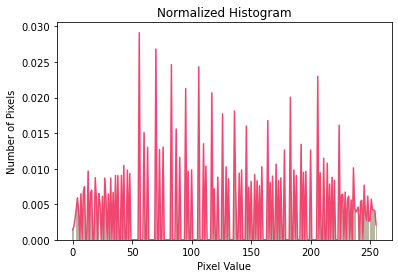

In [14]:
img=cv.imread('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\enh_img_hst\\1-20a11.png')
hist_img, gr_img = generate_histogram(img, print=True, index=1)

eq_hist_arr=equalize_histogram(gr_img, hist_img, L)

In [ ]:
img=cv.imread('F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\enh_img_hst\\1-20b11.png')
hist_img, gr_img = generate_histogram(img, print=True, index=index)

eq_hist_arr_2=equalize_histogram(gr_img, hist_img, L)

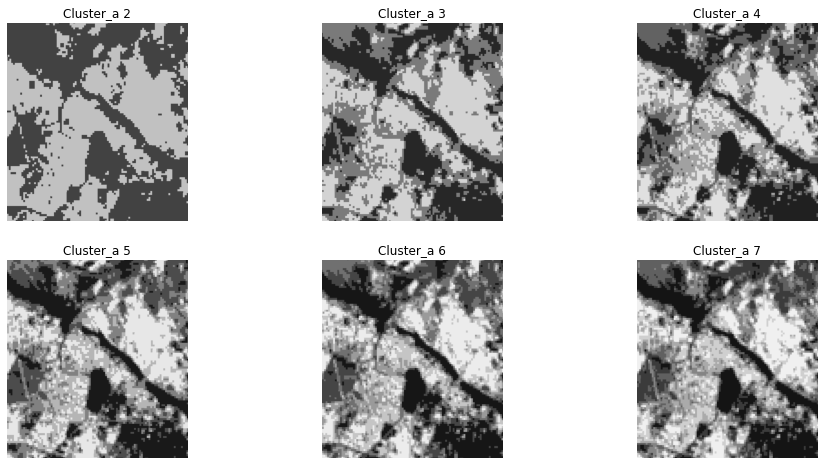

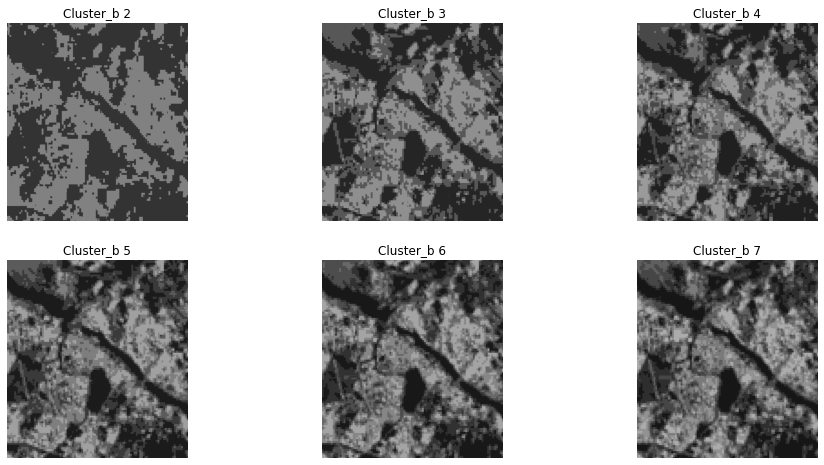

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# read the image
image_a = cv2.imread("F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\enh_img_hst\\1-20a11.png")
image_b = cv2.imread("F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\enh_img_hst\\1-20b11.png")

im_a=image_a/255
pic_a=im_a.reshape(im_a.shape[0]*im_a.shape[1],im_a.shape[2])

im_b=image_b/255
pic_b=im_b.reshape(im_b.shape[0]*im_b.shape[1],im_b.shape[2])

# Since we know 5 segments was looking great on the image we are gonna do 5 clusters here but you can try more too :)
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
count=1
clustered_image=[]
for i in range(2):
    for j in range(3):

        kmeans_a = KMeans(n_clusters=count+1, random_state=0).fit(pic_a)
        pic_a_print = kmeans_a.cluster_centers_[kmeans_a.labels_]
        clustered_pic_a=pic_a_print.reshape(im_a.shape[0],im_a.shape[1],im_a.shape[2])
        clustered_image.append(clustered_pic_a)
        count+=1
        ax[i][j].set_title('Cluster_a '+str(count))
        ax[i][j].imshow(clustered_pic_a)
        ax[i][j].set_axis_off()
plt.show()
#plt.savefig('cluster.png', dpi=300, bbox_inches='tight')
# Since we know 5 segments was looking great on the image we are gonna do 5 clusters here but you can try more too :)
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
count=1
clustered_image=[]
for i in range(2):
    for j in range(3):

        kmeans_b = KMeans(n_clusters=count+1, random_state=0).fit(pic_b)
        pic_b_print = kmeans_b.cluster_centers_[kmeans_b.labels_]
        clustered_pic_b=pic_b_print.reshape(im_b.shape[0],im_b.shape[1],im_b.shape[2])
        clustered_image.append(clustered_pic_b)
        count+=1
        ax[i][j].set_title('Cluster_b '+str(count))
        ax[i][j].imshow(clustered_pic_b)
        ax[i][j].set_axis_off()
plt.show()

In [ ]:
clustered_image_a=[]
image_labels_a=[]

kmeans_a = KMeans(n_clusters=4, random_state=0).fit(pic_a)
pic_a_print = kmeans_a.cluster_centers_[kmeans_a.labels_]
clustered_pic_a=pic_a_print.reshape(im_a.shape[0],im_a.shape[1],im_a.shape[2])
clustered_image_a.append(clustered_pic_a)
image_labels_a.append(kmeans_a.labels_)
#count+=1
#print(i,j)
plt.title('Cluster_a '+'4')
plt.imshow(clustered_pic_a)

In [ ]:
clustered_image_b=[]
image_labels_b=[]

kmeans_b = KMeans(n_clusters=4, random_state=0).fit(pic_b)
pic_b_print = kmeans_b.cluster_centers_[kmeans_b.labels_]
clustered_pic_b=pic_b_print.reshape(im_b.shape[0],im_b.shape[1],im_b.shape[2])
clustered_image_b.append(clustered_pic_a)
image_labels_b.append(kmeans_a.labels_)
#count+=1
#print(i,j)
plt.title('Cluster_b '+'4')
plt.imshow(clustered_pic_b)

In [ ]:
clustered_image_a[0]=clustered_image_a[0]*255

In [ ]:
clustered_image_a_int=clustered_image_a[0].astype(int)

In [ ]:
clustered_image_a_int

In [ ]:
clustered_image_a_int.shape

In [ ]:
image_labels_a[0]

In [ ]:
image_labels_a[0].shape

In [ ]:
img_labels_a=image_labels_a[0].reshape(clustered_image_a_int.shape[0],clustered_image_a_int.shape[1])

In [ ]:
img_labels_a.shape

In [ ]:
seg_region_a_0=clustered_image_a_int.copy()
for i in range(clustered_image_a_int.shape[0]):
    for j in range(clustered_image_a_int.shape[1]):
        if img_labels_a[i][j]==0:
            continue
            #seg_region[i][j][0]=clustered_image_a[0][0]
            #seg_region[i][j][1]=clustered_image_a[0][1]
            #seg_region[i][j][2]=clustered_image_a[0][2]
        else:
            seg_region_a_0[i][j][0]=0
            seg_region_a_0[i][j][1]=0
            seg_region_a_0[i][j][2]=255
            
plt.imshow(seg_region_a_0)

In [ ]:
#im = array(Image.open('empire.jpg'))
print (seg_region_a_0.shape, seg_region_a_0.dtype)

#im = array(Image.open('empire.jpg').convert('L'),'f')
#x=seg_region_a_0.convert('L'),'f'
#print (x.shape, x.dtype)

In [ ]:
seg_region_a_1=clustered_image_a_int.copy()
for i in range(clustered_image_a_int.shape[0]):
    for j in range(clustered_image_a_int.shape[1]):
        if img_labels_a[i][j]==1:
            continue
            #seg_region[i][j][0]=clustered_image_a[0][0]
            #seg_region[i][j][1]=clustered_image_a[0][1]
            #seg_region[i][j][2]=clustered_image_a[0][2]
        else:
            seg_region_a_1[i][j][0]=0
            seg_region_a_1[i][j][1]=0
            seg_region_a_1[i][j][2]=255
            
plt.imshow(seg_region_a_1)

In [ ]:
seg_region_a_2=clustered_image_a_int.copy()
for i in range(clustered_image_a_int.shape[0]):
    for j in range(clustered_image_a_int.shape[1]):
        if img_labels_a[i][j]==2:
            continue
            #seg_region[i][j][0]=clustered_image_a[0][0]
            #seg_region[i][j][1]=clustered_image_a[0][1]
            #seg_region[i][j][2]=clustered_image_a[0][2]
        else:
            seg_region_a_2[i][j][0]=0
            seg_region_a_2[i][j][1]=0
            seg_region_a_2[i][j][2]=255
            
plt.imshow(seg_region_a_2)

In [ ]:
seg_region_a_3=clustered_image_a_int.copy()
for i in range(clustered_image_a_int.shape[0]):
    for j in range(clustered_image_a_int.shape[1]):
        if img_labels_a[i][j]==3:
            continue
            #seg_region[i][j][0]=clustered_image_a[0][0]
            #seg_region[i][j][1]=clustered_image_a[0][1]
            #seg_region[i][j][2]=clustered_image_a[0][2]
        else:
            seg_region_a_3[i][j][0]=0
            seg_region_a_3[i][j][1]=0
            seg_region_a_3[i][j][2]=255
            
plt.imshow(seg_region_a_3)

In [ ]:
clustered_image_b[0]=clustered_image_b[0]*255

In [ ]:
clustered_image_b_int=clustered_image_b[0].astype(int)

In [ ]:
clustered_image_b_int

In [ ]:
image_labels_b[0]

In [ ]:
image_labels_b[0].shape

In [ ]:
img_labels_b=image_labels_b[0].reshape(clustered_image_b_int.shape[0],clustered_image_b_int.shape[1])

In [ ]:
img_labels_b.shape

In [ ]:
seg_region_b_0=clustered_image_b_int.copy()
for i in range(clustered_image_b_int.shape[0]):
    for j in range(clustered_image_b_int.shape[1]):
        if img_labels_b[i][j]==0:
            continue
            #seg_region[i][j][0]=clustered_image_a[0][0]
            #seg_region[i][j][1]=clustered_image_a[0][1]
            #seg_region[i][j][2]=clustered_image_a[0][2]
        else:
            seg_region_b_0[i][j][0]=0
            seg_region_b_0[i][j][1]=0
            seg_region_b_0[i][j][2]=255
            
#plt.imshow(seg_region_b_0)

In [ ]:
seg_region_b_1=clustered_image_b[0].copy()
for i in range(clustered_image_b[0].shape[0]):
    for j in range(clustered_image_b[0].shape[1]):
        if img_labels_b[i][j]==1:
            continue
            #seg_region[i][j][0]=clustered_image_a[0][0]
            #seg_region[i][j][1]=clustered_image_a[0][1]
            #seg_region[i][j][2]=clustered_image_a[0][2]
        else:
            seg_region_b_1[i][j][0]=0
            seg_region_b_1[i][j][1]=0
            seg_region_b_1[i][j][2]=255
            
plt.imshow(seg_region_b_1)

In [ ]:
seg_region_b_2=clustered_image_b[0].copy()
for i in range(clustered_image_b[0].shape[0]):
    for j in range(clustered_image_b[0].shape[1]):
        if img_labels_b[i][j]==2:
            continue
            #seg_region[i][j][0]=clustered_image_a[0][0]
            #seg_region[i][j][1]=clustered_image_a[0][1]
            #seg_region[i][j][2]=clustered_image_a[0][2]
        else:
            seg_region_b_2[i][j][0]=0
            seg_region_b_2[i][j][1]=0
            seg_region_b_2[i][j][2]=255
            
plt.imshow(seg_region_b_2)

In [ ]:
seg_region_b_3=clustered_image_b_int.copy()
for i in range(clustered_image_b_int.shape[0]):
    for j in range(clustered_image_b_int.shape[1]):
        if img_labels_b[i][j]==3:
            continue
            #seg_region[i][j][0]=clustered_image_a[0][0]
            #seg_region[i][j][1]=clustered_image_a[0][1]
            #seg_region[i][j][2]=clustered_image_a[0][2]
        else:
            seg_region_b_3[i][j][0]=0
            seg_region_b_3[i][j][1]=0
            seg_region_b_3[i][j][2]=255
            
plt.imshow(seg_region_b_3)

In [ ]:
# code for displaying multiple images in one figure
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(16, 16))
  
# setting values to rows and column variables
rows = 3
columns = 3
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(image_a)
plt.axis('off')
plt.title("Input Image a")

fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(image_b)
plt.axis('off')
plt.title("Input Image b")

fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(clustered_image_a_int)
plt.axis('off')
plt.title("Clustered Image a")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(clustered_image_b_int)
plt.axis('off')
plt.title("Clustered Image b")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(seg_region_a_0)
plt.axis('off')
plt.title("Segmented Region of a-label0")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(seg_region_b_0)
plt.axis('off')
plt.title("Segmented Region of b-label0")

In [ ]:
# code for displaying multiple images in one figure
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(16, 16))
  
# setting values to rows and column variables
rows = 3
columns = 3
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(image_a)
plt.axis('off')
plt.title("Input Image a")

fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(image_b)
plt.axis('off')
plt.title("Input Image b")

fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(clustered_image_a_int)
plt.axis('off')
plt.title("Clustered Image a")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(clustered_image_b_int)
plt.axis('off')
plt.title("Clustered Image b")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(seg_region_a_1)
plt.axis('off')
plt.title("Segmented Region of a-label1")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(seg_region_b_1)
plt.axis('off')
plt.title("Segmented Region of b-label1")

In [ ]:
# code for displaying multiple images in one figure
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(16, 16))
  
# setting values to rows and column variables
rows = 3
columns = 3
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(image_a)
plt.axis('off')
plt.title("Input Image a")

fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(image_b)
plt.axis('off')
plt.title("Input Image b")

fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(clustered_image_a_int)
plt.axis('off')
plt.title("Clustered Image a")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(clustered_image_b_int)
plt.axis('off')
plt.title("Clustered Image b")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(seg_region_a_2)
plt.axis('off')
plt.title("Segmented Region of a-label2")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(seg_region_b_2)
plt.axis('off')
plt.title("Segmented Region of b-label2")

In [ ]:
# code for displaying multiple images in one figure
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(16, 16))
  
# setting values to rows and column variables
rows = 3
columns = 3
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(image_a)
plt.axis('off')
plt.title("Input Image a")

fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(image_b)
plt.axis('off')
plt.title("Input Image b")

fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(clustered_image_a_int)
plt.axis('off')
plt.title("Clustered Image a")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(clustered_image_b_int)
plt.axis('off')
plt.title("Clustered Image b")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(seg_region_a_3)
plt.axis('off')
plt.title("Segmented Region of a-label3")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(seg_region_b_3)
plt.axis('off')
plt.title("Segmented Region of b-label3")

In [ ]:
gray_a_3 = seg_region_a_3[:,:,0]

In [ ]:
gray_b_3 = seg_region_b_3[:,:,0]

In [ ]:
plt.imshow(gray_a_3)

In [ ]:
plt.imshow(gray_b_3)

In [ ]:
edge_a_3=edge_detection(gray_a_3)

In [ ]:
plt.imshow(edge_a_3)

In [ ]:
edge_b_3=edge_detection(gray_b_3)

In [ ]:
plt.imshow(edge_b_3)

In [ ]:
from skimage import io
from skimage.filters import threshold_otsu
img_a = gray_a_3
##################################################
#Variance - not a great way to quantify texture
from scipy import ndimage 
k=7
img_mean_a = ndimage.uniform_filter(img_a, (k, k))
img_sqr_mean_a = ndimage.uniform_filter(img_a**2, (k, k))
img_var_a = img_sqr_mean_a - img_mean_a**2
plt.imshow(img_var_a, cmap='gray')

#######################################################
#GABOR - A great filter for texture but usually efficient
#if we know exact parameters. Good choice for generating features
#for machine learning

ksize=45
theta=np.pi/4
kernel_a = cv2.getGaborKernel((ksize, ksize), 5.0, theta, 10.0, 0.9, 0, ktype=cv2.CV_32F)
filtered_image_a = cv2.filter2D(img_a, cv2.CV_8UC3, kernel)
plt.imshow(filtered_image_a, cmap='gray')

###########################################################
#Entropy
#Entropy quantifies disorder.
#Since cell region has high variation in pixel values the entropy would be
#higher compared to scratch region
from skimage.filters.rank import entropy
from skimage.morphology import disk
entropy_img_a = entropy(img_a, disk(3))
#plt.imshow(entropy_img_a)

#Scratch Analysis - single image
#Now let us use otsu to threshold high vs low entropy regions.
plt.hist(entropy_img_a.flat, bins=100, range=(0,5))  #.flat returns the flattened numpy array (1D)

thresh_a = threshold_otsu(entropy_img_a)

#Now let us binarize the entropy image 
binary_a = entropy_img_a <= thresh_a
plt.imshow(binary_a)

#Sum all pixels in the scratch region (values =1)
scratch_area_a = np.sum(binary_a == 1)
print("Scratched area is: ", scratch_area_a, "Square pixels")

scale = 0.45 # microns/pixel
print("Scratched area in sq. microns is: ", scratch_area_a*((scale)**2), "Square pixels")

In [ ]:
from skimage import io
from skimage.filters import threshold_otsu
img_b = gray_b_3
##################################################
#Variance - not a great way to quantify texture
from scipy import ndimage 
k=7
img_mean_b = ndimage.uniform_filter(img, (k, k))
img_sqr_mean_b = ndimage.uniform_filter(img**2, (k, k))
img_var_b = img_sqr_mean_b - img_mean_b**2
plt.imshow(img_var_b, cmap='gray')

#######################################################
#GABOR - A great filter for texture but usually efficient
#if we know exact parameters. Good choice for generating features
#for machine learning

ksize=45
theta=np.pi/4
kernel_b = cv2.getGaborKernel((ksize, ksize), 5.0, theta, 10.0, 0.9, 0, ktype=cv2.CV_32F)
filtered_image_b = cv2.filter2D(img_b, cv2.CV_8UC3, kernel)
plt.imshow(filtered_image_b, cmap='gray')

###########################################################
#Entropy
#Entropy quantifies disorder.
#Since cell region has high variation in pixel values the entropy would be
#higher compared to scratch region
from skimage.filters.rank import entropy
from skimage.morphology import disk
entropy_img_b = entropy(img_b, disk(3))
plt.imshow(entropy_img_b)

#Scratch Analysis - single image
#Now let us use otsu to threshold high vs low entropy regions.
plt.hist(entropy_img_b.flat, bins=100, range=(0,5))  #.flat returns the flattened numpy array (1D)

thresh_b = threshold_otsu(entropy_img)

#Now let us binarize the entropy image 
binary_b = entropy_img_b <= thresh_b
plt.imshow(binary_b)

#Sum all pixels in the scratch region (values =1)
scratch_area_b = np.sum(binary_b == 1)
print("Scratched area is: ", scratch_area, "Square pixels")

scale = 0.45 # microns/pixel
print("Scratched area in sq. microns is: ", scratch_area_b*((scale)**2), "Square pixels")

In [ ]:
# code for displaying multiple images in one figure
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(16, 16))
  
# setting values to rows and column variables
rows = 5
columns = 5
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(image_a)
plt.axis('off')
plt.title("Input Image a")

fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(image_b)
plt.axis('off')
plt.title("Input Image b")

fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(clustered_image_a_int)
plt.axis('off')
plt.title("Clustered Image a")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(clustered_image_b_int)
plt.axis('off')
plt.title("Clustered Image b")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(seg_region_a_3)
plt.axis('off')
plt.title("Segmented Region of a-label3")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 6)

# showing image
plt.imshow(seg_region_b_3)
plt.axis('off')
plt.title("Segmented Region of b-label3")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(binary_a)
plt.axis('off')
plt.title("Texture Region of a-label3")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 8)

# showing image
plt.imshow(binary_b)
plt.axis('off')
plt.title("Texture Region of b-label3")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 9)

# showing image
plt.imshow(edge_a_3)
plt.axis('off')
plt.title("Edge Detection of a-label3")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 10)

# showing image
plt.imshow(edge_b_3)
plt.axis('off')
plt.title("Edge Detection of b-label3")

In [ ]:
from scipy.linalg import norm
def compare_images(img1, img2):
    # normalize to compensate for exposure difference, this may be unnecessary
    # consider disabling it
    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = sum(abs(diff))  # Manhattan norm
    z_norm = norm(diff.ravel(), 0)  # Zero norm
    return (m_norm, z_norm)

In [ ]:
def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*255/rng

In [ ]:
# A Python program to print all
# permutations using library function
from itertools import permutations
 
# Get all permutations of [1, 2, 3]
perm = permutations([0,1, 2, 3],2)
 
# Print the obtained permutations
for i in list(perm):
    print (i)

In [ ]:
import matplotlib.pylab as pylab
image_b = cv2.imread("F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\enh_img_hst\\1-20b11.png")
# histogram equalization
#img_eq = exposure.equalize_hist(img)
# adaptive histogram equalization
#img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
pylab.gray()
images_b = [image_b, clustered_image_b_int, seg_region_b_3]
titles = ['Input Image', 'Clustered Image of b label=3', 'Segmented Image of b label=3']
for i in range(3):
    pylab.figure(figsize=(20,10)), plot_image(images_b[i], titles[i])
pylab.figure(figsize=(15,5))
for i in range(3):
    pylab.subplot(1,3,i+1), pylab.hist(images_b[i].ravel(), color='g'), pylab.title(titles[i], size=15)
pylab.show()

In [ ]:
import matplotlib.pylab as pylab
import cv2
image_a = cv2.imread("F:\\data_science\\Blu-Cocoon\\Geotagging\\Sentinel-2 Multitemporal Cities Pairs (S2MTCP) dataset\\data_S21C\\Overlapping-NonOverlapping\\enh_img_hst\\1-20a11.png")
# histogram equalization
#img_eq = exposure.equalize_hist(img)
# adaptive histogram equalization
#img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
pylab.gray()
images_a = [image_a, clustered_image_a_int, seg_region_a_3]
titles = ['Input Image', 'Clustered Image of a label=3', 'Segmented Image of a label=3']
for i in range(3):
    pylab.figure(figsize=(20,10)), plot_image(images_a[i], titles[i])
pylab.figure(figsize=(15,5))
for i in range(3):
    pylab.subplot(1,3,i+1), pylab.hist(images_a[i].ravel(), color='g'), pylab.title(titles[i], size=15)
    x,y,_=plt.hist(images_a)
    print(x)
pylab.show()

In [ ]:
def plot_image(image, title=''):
    pylab.title(title, size=20), pylab.imshow(image)
    pylab.axis('off') # comment this line if you want axis ticks